Loads all PyG graphs and corresponding ids

In [1]:
import torch, os
from omegaconf import OmegaConf
from LayoutGKN.utils import load_pickle
cfg = OmegaConf.load("../cfg.yaml")
dir_rplan = os.path.join(cfg.path_data, "rplan")
graphs, ids = [], []
for mode in ["train", "val", "test"]:
    ids_mode, graphs_mode = torch.load(os.path.join(dir_rplan, f"pyg_graphs_{mode}_Ms.pt"), weights_only=False)
    graphs.extend(graphs_mode)
    ids.extend(ids_mode)
print(len(ids))

72389


In [2]:
G = graphs[0]
print(G.num_nodes)
print(G.shp.shape)
print(int(G.pid))

7
torch.Size([7, 16])
39514


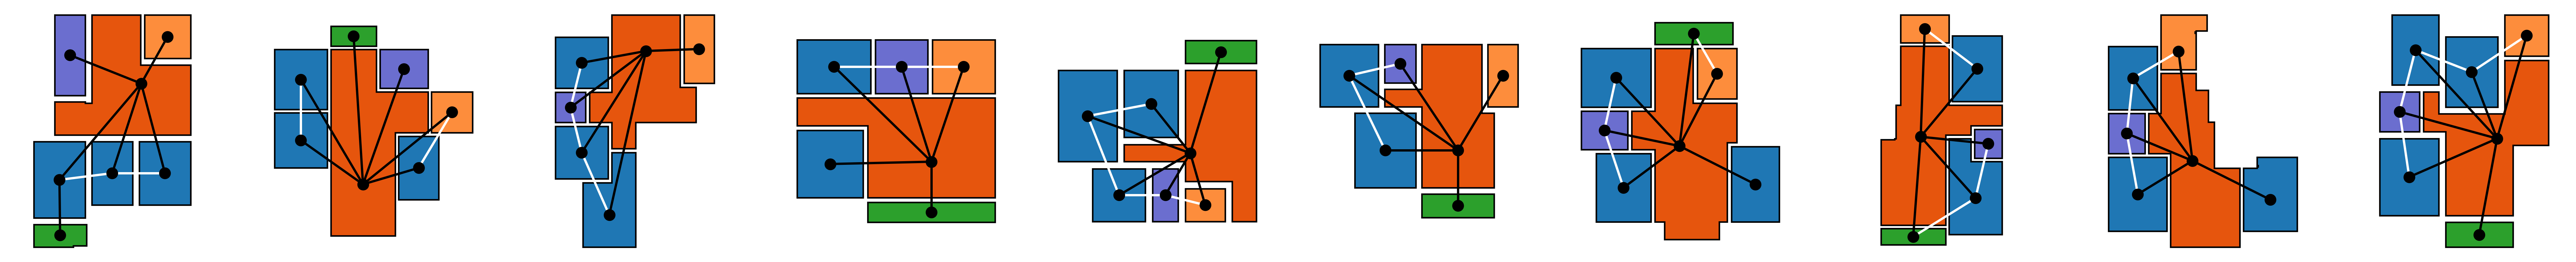

In [3]:
import matplotlib.pyplot as plt
from LayoutGKN.plot import draw_graph
nx_graphs = load_pickle(os.path.join(dir_rplan, "nx_graphs.pkl"))
nx_ids = [G.graph["pid"] for G in nx_graphs]

n, fs = 10, 10
fig, axs = plt.subplots(1,n,figsize=(n*fs,fs)); axs = axs.flatten()
for ax, G in zip(axs, graphs):
    pid = int(G.pid)
    G = nx_graphs[nx_ids.index(pid)]
    ax.axis("equal"); ax.axis('off')
    draw_graph(ax, G, fs=fs, s=fs*6, w=fs/2, lw=fs/3)

Load similarity dataframe.

In [4]:
import pandas as pd
df_sim = pd.read_pickle(os.path.join(dir_rplan, "df similarity (train).df"))
df_sim.head(5)

,Query ID,IDs,MIoU,GED,sGED
0,0,"[0, 10029, 38303, 65564, 6222, 17269, 66271, 2...","[1.0, 0.9292821757131564, 0.6091558696152071, ...","[0.0, 0.0, 4.0, 2.0, 5.0, 0.0, 2.0, 0.0, 0.0, ...","[1.0, 1.0, 0.5404329964865341, 0.7165313105737..."
1,1,"[1, 34531, 17669, 10426, 17727, 64797, 31670, ...","[1.0, 0.4923791216413143, 0.4480427469654953, ...","[0.0, 1.0, 0.0, 4.0, 0.0, 2.0, 4.0, 4.0, 2.0, ...","[1.0, 0.8668778997501816, 1.0, 0.5404329964865..."
2,2,"[2, 50409, 60643, 45395, 14511, 4561, 9965, 77...","[1.0, 0.4715524934257102, 0.4698465137443172, ...","[0.0, 6.0, 5.0, 2.0, 6.0, 2.0, 7.0, 4.0, 4.0, ...","[1.0, 0.44932896411722156, 0.4633693692311753,..."
3,7,"[7, 67118, 29509, 29390, 40936, 7832, 8998, 30...","[1.0, 0.5652887670104647, 0.5166189168859271, ...","[0.0, 3.0, 5.0, 5.0, 5.0, 6.0, 6.0, 2.0, 5.0, ...","[1.0, 0.6872892787909722, 0.5352614285189903, ..."
4,9,"[9, 41340, 32725, 58709, 14427, 80720, 17589, ...","[1.0, 0.9712387100602147, 0.4994756391293305, ...","[0.0, 0.0, 6.0, 7.0, 4.0, 7.0, 8.0, 6.0, 6.0, ...","[1.0, 1.0, 0.44932896411722156, 0.367879441171..."


In [5]:
print(len(df_sim))  # size of training data set
ids_train = df_sim.loc[df_sim["IDs"].map(len) > 1, "Query ID"]  # loads all plan IDs that have ranks
print(len(ids_train))

36850
36850


Generates triplets for training

In [6]:
import random
def shuffle_dict(dict):
    """Randomly shuffles a dictionary."""
    keys =  list(dict.keys())      # Python 3; use keys = d.keys() in Python 2
    random.shuffle(keys)
    return {key: dict[key] for key in keys}


def generate_triplets(IDa, similarities, ap_lim, rel_lim):
    """Generate triplets (A, P, N) based on the given constraints."""
    # filters positives
    positives = [key for key, score in similarities if ap_lim[0] <= score <= ap_lim[1]]
    score_dict = {key: score for key, score in similarities}
    trips = []
    for IDp in positives:
        score_p = score_dict[IDp]
        score_dict = shuffle_dict(score_dict)
        for IDn, score_n in score_dict.items():
            # finds ALL possible negatives
            if score_p * rel_lim[0] < score_n < score_p * rel_lim[1]:
                trips.append((IDa, IDp, IDn, score_p, score_n))
                break  # max add one positive per anchor
    return trips

Gather information

In [7]:
pid = ids_train[0]
row = df_sim.set_index('Query ID').loc[pid]  # one lookup
key_scores = list(zip(row['IDs'][1:], row['sGED'][1:]))  # id-score pairs
print(f"k={len(key_scores)}")
print(key_scores[:10])

k=49
[(10029, 1.0), (38303, 0.5404329964865341), (65564, 0.7165313105737893), (6222, 0.4633693692311753), (17269, 1.0), (66271, 0.7351414805916845), (20656, 1.0), (7435, 1.0), (32918, 1.0), (69834, 0.8464817248906141)]


Generate triplets

In [9]:
ap_lim = [0.6, 1.0]  # to make sure anchor is similar to positive
rel_lim = [0.7, 0.9]  # to ascertain hard-negatives
trips = generate_triplets(pid, key_scores, ap_lim, rel_lim)
print(f"Found {len(trips)} triplets\n")
print(f"First 5 (A, P, N, dAP, dAN):")
print(*trips[:5], sep='\n')

Found 28 triplets

First 5 (A, P, N, dAP, dAN):
(0, 10029, 68092, 1.0, 0.8464817248906141)
(0, 65564, 23942, 0.7165313105737893, 0.5795782787848095)
(0, 17269, 29323, 1.0, 0.8464817248906141)
(0, 66271, 43988, 0.7351414805916845, 0.5404329964865341)
(0, 20656, 69834, 1.0, 0.8464817248906141)


In [10]:
from tqdm import tqdm
from torch_geometric.data import Batch

def create_graph_triplet(trip, graphs, id_to_idx):
    """Creates a single graph for the triplet."""
    IDa, IDp, IDn, *_ = trip
    data_triplet = []
    seq = [IDa, IDp, IDa, IDn]
    for j, pid in enumerate(seq):
        data = graphs[id_to_idx[pid]].clone()
        N = data.num_nodes
        # order as node attribute: needed for graph Siamese networks
        data.order = torch.full((N,), j, dtype=torch.long)
        data_triplet.append(data)
    # merge graphs and convert to PyG format
    return Batch.from_data_list(data_triplet)

In [11]:
# check values
id_to_idx = {pid: i for i, pid in enumerate(ids)}  # for fast lookup
data = create_graph_triplet(trips[0], graphs, id_to_idx)
print(data.order)
print(data.pid)

tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3])
tensor([    0, 10029,     0, 68092])


Preparing data function check:

In [12]:
def prep_data(data, device):
    """Prepares the graph data from DataBatch of the PyG Dataloader"""
    data = data.to(device)
    return (
        data.edge_index,
        data.geometry.float(),
        data.category.long(),
        data.connectivity.long(),
        data.batch,
    )

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ei, xn_geom, xn_cats, xe, batch = prep_data(data, device)
print(batch)

tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3],
       device='cuda:0')


Works all fine and dandy.

Now, get all triplets.

In [14]:
id_to_idx = {pid: i for i, pid in enumerate(ids)}
ap_lim = [0.6, 1.0]  # to make sure anchor is similar to positive
rel_lim = [0.7, 0.9]  # to ascertain hard-negatives
ids_overlap = list(set(ids_train).intersection(set(ids)))

trips = []
for pid in tqdm(ids_overlap):
    row = df_sim.set_index('Query ID').loc[pid]  # one lookup
    key_scores = list(zip(row['IDs'][1:], row['sGED'][1:]))
    trips_id = generate_triplets(pid, key_scores, ap_lim, rel_lim)
    # no more than 5 triplets per ID
    if len(trips_id) > 5: trips_id = random.sample(trips_id, k=5)
    trips.extend(trips_id)

100%|██████████| 35980/35980 [01:16<00:00, 473.04it/s]


In [16]:
print(len(trips))

166601


Populate with actual graphs

In [21]:
trips_graphs = []
for trip in tqdm(trips):
    try: trips_graphs.append(create_graph_triplet(trip, graphs, id_to_idx))
    except: pass

100%|██████████| 166601/166601 [01:04<00:00, 2565.98it/s]


In [20]:
torch.save(trips_graphs, os.path.join(dir_rplan, "trips_graphs_train.pt"))